## 实施主要包含以下几个步骤:

- 导入相关包
- 数据预处理
- 导出特征向量（不需要重复计算）


## 步骤一：导入相关包

In [1]:
import os
import shutil
from keras.models import *
from keras.layers import *
from keras.applications import *
from keras.preprocessing.image import *
from keras.callbacks import ModelCheckpoint, TensorBoard

import h5py
import numpy as np
from sklearn.utils import shuffle
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.preprocessing.image import ImageDataGenerator

import seaborn as sns
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


## 步骤二：数据预处理

从 https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition/ 下载训练数据到image目录数据集中 image/train/里的猫狗没有分类，放在一个文件夹，因为需要使用keras，需要将训练照片按照类别文件夹分类，其中猫放在一个文件夹，狗放在一个文件夹。把数据按照4:1拆分成训练集和验证集合
结构如下：

```
├── image
│   ├── test
│   ├── test2
│   │   └── test -> ../test/
│   ├── train
│   ├── train2
│   │   ├── cat
│   │   └── dog
```


In [2]:
os.chdir("{}/image".format(os.getcwd())) 
train_filenames = os.listdir('train')
train_cat = filter(lambda x:x[:3] == 'cat', train_filenames)
train_dog = filter(lambda x:x[:3] == 'dog', train_filenames)

def rmrf_mkdir(dirname):
    if os.path.exists(dirname):
        shutil.rmtree(dirname)
    os.mkdir(dirname)

rmrf_mkdir('train2')
os.mkdir('train2/cat')
os.mkdir('train2/dog')

rmrf_mkdir('test2')
os.symlink('../test/', 'test2/test')

for filename in train_cat:
    os.symlink('../../train/'+filename, 'train2/cat/'+filename)

for filename in train_dog:
    os.symlink('../../train/'+filename, 'train2/dog/'+filename)
os.chdir("..")     
print("os finish")

os finish


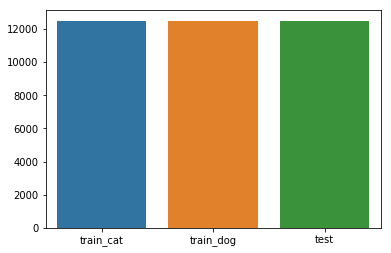

In [3]:
train_files = os.listdir('image/train')
train_cat = [x for x in train_files if 'cat' in x]
train_dog = [x for x in train_files if 'dog' in x]
train_total = np.concatenate((train_cat,train_dog))

x = ['train_cat', 'train_dog', 'test']
y = [len(train_cat), len(train_dog), len(os.listdir('image/test'))]
ax = sns.barplot(x=x, y=y)
plt.savefig('matplotlib/fenbu.jpg')

In [4]:
## 现实所有图片尺寸
type(train_total)
def get_shape(img_arr):
    sum = 0
    shape_list = []
    for index in img_arr:
        sum += 1
        img = cv2.imread("image/train/%s" % index)
        shape_list.append([img.shape[0],img.shape[1]])
    return (shape_list)
    
shape_list = get_shape(train_total)

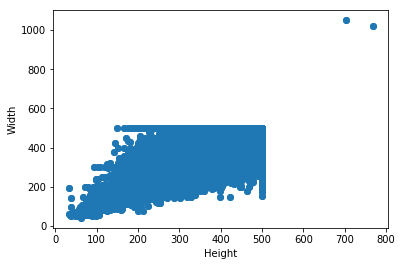

In [5]:
# 绘制散点分布图
x_index = [i[0] for i in shape_list]
y_index = [i[1] for i in shape_list]

plt.scatter(x_index,y_index)
plt.xlabel('Height')
plt.ylabel('Width')
plt.plot(x_index,y_index,'o')
#plt.show()
plt.savefig('matplotlib/hwscatter.jpg')

## 采用预处理模型剔除异常数据

In [8]:
img_size = (299, 299)
## 载入预先下载好的ImageNet分类csv文件
import csv
from keras.preprocessing import image
from keras.applications.inception_v3 import preprocess_input
from tqdm import tqdm

def get_imageNet_class(file_path):
    category_class = []
    with open(file_path,'r') as f:
        reader = csv.reader(f)
        for line in reader:
            if(line[1] == '猫') or (line[1] == '狗'):
                category_class.append(line[0])
    return (category_class)

def conv_img_path(img_arr):
    dir_path = []
    for i in train_total:
        dir_path.append('image/train/%s' % i)
    return (dir_path)

def read_image(img_path):
    img = image.load_img('%s' % img_path,target_size=img_size)
    x = image.img_to_array(img)
    x = np.expand_dims(x,axis=0)
    x = preprocess_input(x)
    return (x)

def read_image_dir(dir_list):
    preprocess_imgs = [read_image(fp) for fp in tqdm(dir_arr)]
    return (preprocess_imgs)

imageNet_class = get_imageNet_class('ImageNetClasses.csv')

#转换路径
dir_arr = conv_img_path(train_total)
#获取归一化后图片
preprocess_imgs = read_image_dir(dir_arr)

100%|██████████| 25000/25000 [01:03<00:00, 392.05it/s]


In [11]:
from keras.applications.inception_v3 import decode_predictions

def predict_model(model,imgs,top = 10):
    pred = model.predict(imgs)
    return (decode_predictions(pred,top=top)[0])

def get_predict(model,imgs,top=10):
    result = [ predict_model(model, x, top) for x in tqdm(imgs) ]
    return(result)
        
model= InceptionV3(weights='imagenet')

##预测模型
pred = get_predict(model, preprocess_imgs, 50)

96124928/96112376 [==============================] - 16s 0us/step


  0%|          | 0/25000 [00:00<?, ?it/s]

49152/35363 [=========================================] - 0s 4us/step


100%|██████████| 25000/25000 [07:17<00:00, 57.16it/s]


26


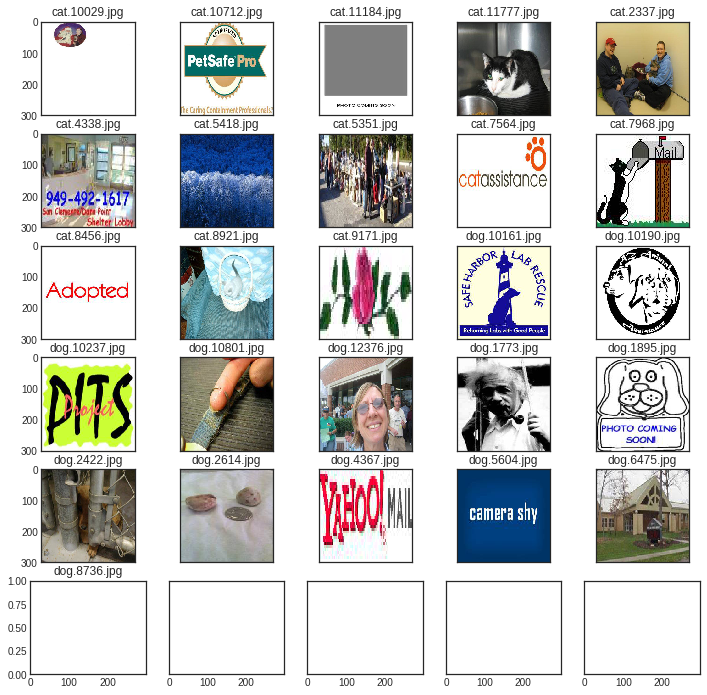

In [17]:
# 获取能match到猫狗类型的预测总数
def get_result_list(pred):
    result = []
    for item in pred:
        pred_list = [ x[0] for x in item ]
        pred_list = [ 1 for x in pred_list if x in imageNet_class ]
        result.append(sum(pred_list))
    return(result)

# 获取异常数据的文件名
right_list = get_result_list(pred)
exp_flist = []
for index, value in enumerate(right_list):
    if value == 0:
        exp_flist.append(train_total[index])
        

plt.style.use('seaborn-white')
#查看图片内容
fig,ax = plt.subplots(6,5,sharex='col',sharey='row',figsize=(12,12))

print (len(exp_flist))
index = 0
for i in range(5):
    for j in range(5):
        img = image.load_img("image/train/%s" % exp_flist[index],target_size=img_size)
        ax[i,j].set_title('%s'% exp_flist[index])
        ax[i,j].imshow(img)
        index+=1
#最后一张
img = image.load_img("image/train/%s" % exp_flist[-1],target_size=img_size)
ax[5,0].set_title('%s'% exp_flist[-1])
# ax[5,0].imshow(img)
fig.savefig("matplotlib/error.jpg")


In [18]:
#剔除异常值
exp_arr = np.array(exp_flist)
nor_arr = np.array(['cat.8921.jpg','cat.11777.jpg','cat.2337.jpg'])
manual_arr = np.array(['cat.92.jpg','cat.7377.jpg','cat.4085.jpg'])

need_delete_arr = []
for file_name in exp_arr:
    if file_name not in nor_arr:
        need_delete_arr.append(file_name)
        
need_delete_arr = np.concatenate((np.array(need_delete_arr),np.array(manual_arr)))
need_delete_arr 

array(['cat.10029.jpg', 'cat.10712.jpg', 'cat.11184.jpg', 'cat.4338.jpg',
       'cat.5418.jpg', 'cat.5351.jpg', 'cat.7564.jpg', 'cat.7968.jpg',
       'cat.8456.jpg', 'cat.9171.jpg', 'dog.10161.jpg', 'dog.10190.jpg',
       'dog.10237.jpg', 'dog.10801.jpg', 'dog.12376.jpg', 'dog.1773.jpg',
       'dog.1895.jpg', 'dog.2422.jpg', 'dog.2614.jpg', 'dog.4367.jpg',
       'dog.5604.jpg', 'dog.6475.jpg', 'dog.8736.jpg', 'cat.92.jpg',
       'cat.7377.jpg', 'cat.4085.jpg'], dtype='|S13')

In [20]:
#删除操作
for file_name in need_delete_arr:
    path = 'image/train/%s' %file_name
    if os.path.exists(path):
        os.remove(path)
    else:
        print ('no such file:%s'% file_name)

In [21]:
#删除后统计图片张数
print(len(need_delete_arr))
!echo "cats | $(find image/train/ -name 'cat*' | wc -l)"
!echo "dogs | $(find image/train/ -name 'dog*' | wc -l)"

26
cats | 12487
dogs | 12487


In [ ]:
after_delete_train_cat = [img for img in filter(lambda x:x[:3] == 'cat', train_filenames)]
after_delete_train_dog = [img for img in filter(lambda x:x[:3] == 'dog', train_filenames)]

def build_mkdir(dirname):
    if os.path.exists(dirname):
        #delete old direct
        shutil.rmtree(dirname)
    os.mkdir(dirname)

build_mkdir('image/train2')
os.mkdir('image/train2/cat')
os.mkdir('image/train2/dog')

#copy files to new path
def copy_to_newPath(oldPath,newPath,imgName):
    for img in imgName:
        pathA = oldPath + img
        pathB = newPath + img
        shutil.copyfile(pathA,pathB)
        
copy_to_newPath('image/train/','image/train2/cat/',after_delete_train_cat)
copy_to_newPath('image/train/','image/train2/dog/',after_delete_train_dog)

## 步骤二：导出特征向量（不需要重复计算）

In [25]:

def write_gap(MODEL, image_size, lambda_func=None):
    width = image_size[0]
    height = image_size[1]
    input_tensor = Input((height, width, 3))
    x = input_tensor
    if lambda_func:
        x = Lambda(lambda_func)(x)
    
    base_model = MODEL(input_tensor=x, weights='imagenet', include_top=False)
    model = Model(base_model.input, GlobalAveragePooling2D()(base_model.output))

    gen = ImageDataGenerator()
    train_generator = gen.flow_from_directory("image/train2", image_size, shuffle=False, 
                                              batch_size=128)
    test_generator = gen.flow_from_directory("image/test2", image_size, shuffle=False, 
                                             batch_size=128, class_mode=None)
    print('train = 1111')
    train_filenames = train_generator.filenames
    train_samples = len(train_filenames)

    test_filenames = test_generator.filenames
    test_samples = len(test_filenames)
    
    train = model.predict_generator(train_generator, train_samples)
    print('train = ', train)
    test = model.predict_generator(test_generator, test_samples)
    with h5py.File("assets/gap_%s.h5"%MODEL.__name__) as h:
        print('begin train')
        h.create_dataset("train", data=train)
        print('begin test')
        h.create_dataset("test", data=test)
        print('begin label')
        h.create_dataset("label", data=train_generator.classes)
        print('finish')

In [26]:
write_gap(ResNet50, (224, 224))

/home/ubuntu/anaconda3/envs/dogvscat/lib/python2.7/site-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


Found 70 images belonging to 2 classes.
Found 12500 images belonging to 1 classes.
train = 1111
('train = ', array([[1.3505087 , 0.620004  , 1.0053121 , ..., 0.06113218, 0.23388642,
        0.03284767],
       [0.24835415, 1.0159256 , 0.01795574, ..., 1.0741072 , 0.00818987,
        0.        ],
       [0.12362354, 0.        , 0.0201174 , ..., 0.1956835 , 0.10748149,
        0.2352063 ],
       ...,
       [0.18062173, 0.26328593, 0.04289311, ..., 0.06809879, 0.04470628,
        0.9427253 ],
       [0.90272444, 0.5301376 , 0.05386477, ..., 0.4166416 , 0.08936773,
        0.04916259],
       [0.05291175, 0.00624715, 0.08565086, ..., 0.04765116, 0.3548847 ,
        0.22180407]], dtype=float32))


KeyboardInterrupt: 

In [ ]:
write_gap(InceptionV3, (299, 299), inception_v3.preprocess_input)

In [ ]:
write_gap(VGG16, (299, 299))